# Amazon Product Review Sentiment Analysis

In [1]:
# Some installation commands
#!python -m spacy download en_core_web_sm
#!pip install gensim
#!pip install --upgrade jupyterthemes

In [2]:
# Command to change theme
#!jt -t onedork

In [3]:
# All the needed imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('dark_background')
%matplotlib inline
import plotly.graph_objects as go
#from chart_studio.plotly import iplot
from plotly.offline import iplot
import seaborn as sns
import re
import string
import math
import random
import copy
from textblob import TextBlob
from wordcloud import WordCloud
import contractions
import textstat

import torch
import torchtext

import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.probability import FreqDist
from nltk.tokenize import sent_tokenize

from spellchecker import SpellChecker

from gensim.models import word2vec

import spacy

from bs4 import BeautifulSoup

import collections
from collections import defaultdict
from textwrap import wrap

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

import sklearn
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

from keras.models import Sequential
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, GlobalAveragePooling1D, Dense

#from boilerpy3 import extractors

import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

OSError: [WinError 1455] O ficheiro de estrutura de página é demasiado pequeno para que esta operação seja concluída. Error loading "D:\Users\Estudo\anaconda3\lib\site-packages\torch\lib\caffe2_detectron_ops.dll" or one of its dependencies.

In [4]:
#nltk.download('punkt')
#nltk.download('averaged_perceptron_tagger')
#nltk.download('wordnet')
#nltk.download('stopwords')

## 1 - DATA COLLECTION

These are the 2 datasets available for the sentiment analysis task on amazon product review. One is train data and the other one is for test purpose on the model.

In [5]:
amazon_reviews_train = pd.read_csv('amazon_reviews_train.csv')
amazon_reviews_test = pd.read_csv('amazon_reviews_test.csv')

To do the basic processing for all documents let's try to merge the 2 datasets and make the basic exploration and preprocessing on them

In [6]:
amazon_reviews = pd.concat([amazon_reviews_train, amazon_reviews_test])
amazon_reviews.reset_index(inplace=True, drop=True)
amazon_reviews

sentiment                                             review
0      negative  Product arrived labeled as Jumbo Salted Peanut...
1      positive  This is a confection that has been around a fe...
2      negative  If you are looking for the secret ingredient i...
3      positive  Great taffy at a great price.  There was a wid...
4      positive  This saltwater taffy had great flavors and was...
...         ...                                                ...
51314  positive  Flavor of this broth was spot on!  I have been...
51315  positive  Yes! I don't have a pho restaurant anywhere ne...
51316  positive  I fell in love with Pho on the east coast and ...
51317  negative  Altho this is a good pho base to make at home,...
51318  negative  when i first received this product, i was psyc...

[51319 rows x 2 columns]

Let's make a copy to prevent actions that may turn out to be irreversible 

In [7]:
amazon_reviews_copy = copy.copy(amazon_reviews)
amazon_reviews_copy

sentiment                                             review
0      negative  Product arrived labeled as Jumbo Salted Peanut...
1      positive  This is a confection that has been around a fe...
2      negative  If you are looking for the secret ingredient i...
3      positive  Great taffy at a great price.  There was a wid...
4      positive  This saltwater taffy had great flavors and was...
...         ...                                                ...
51314  positive  Flavor of this broth was spot on!  I have been...
51315  positive  Yes! I don't have a pho restaurant anywhere ne...
51316  positive  I fell in love with Pho on the east coast and ...
51317  negative  Altho this is a good pho base to make at home,...
51318  negative  when i first received this product, i was psyc...

[51319 rows x 2 columns]

In [8]:
print("Shape: " + str(amazon_reviews_copy.shape))
print(amazon_reviews_copy.info())

Shape: (51319, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51319 entries, 0 to 51318
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  51319 non-null  object
 1   review     51319 non-null  object
dtypes: object(2)
memory usage: 802.0+ KB
None


Check the first 20 rows in the dataset. It's important to, at first glance, get a little sense of what's written in reviews.

In [9]:
pd.set_option("max_colwidth", None)
amazon_reviews_copy.head(20)

sentiment  \
0   negative   
1   positive   
2   negative   
3   positive   
4   positive   
5   positive   
6   positive   
7   negative   
8   positive   
9   positive   
10  negative   
11  positive   
12  positive   
13  positive   
14  positive   
15  positive   
16  positive   
17  positive   
18  negative   
19  positive   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         review  
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as "Jumbo".  
1                                                                                                                                                                                                                                                                                 This is a confection that has been around a few centuries.  It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with powdered sugar.  And it is a tiny mouthful of heaven.  Not too chewy, and very flavorful.  I highly recommend this yummy treat.  If you are familiar with the story of C.S. Lewis' "The Lion, The Witch, and The Wardrobe" - this is the treat that seduces Edmund into selling out his Brother and Sisters to the Witch.  
2                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   If you are looking for the secret ingredient in Robitussin I believe I have found it.  I got this in addition to the Root Beer Extract I ordered (which was good) and made some cherry soda.  The flavor is very medicinal.  
3                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

Now, the last 20 rows:

In [10]:
amazon_reviews_copy.tail(20)

sentiment  \
51299  positive   
51300  positive   
51301  positive   
51302  negative   
51303  positive   
51304  negative   
51305  positive   
51306  positive   
51307  positive   
51308  negative   
51309  negative   
51310  positive   
51311  positive   
51312  positive   
51313  positive   
51314  positive   
51315  positive   
51316  positive   
51317  negative   
51318  negative   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           review  
51299                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              This Hot and Sour soup is excellent! We like to enhance it some with a little extra spice (habanero powder), some firm tofu, chinese dried black mushrooms, egg and scallions.  
51300                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

## 2 - DATA PREPARATION

### 2.1 - DOCUMENT PREPROCESSING

#### 2.1.1 - DATA CLEANING

As seen above, in the reviews column, there are some characters or sets of characters that will not be needed (they will be harmful, better said) when we have to put the text in machine learning classifiers. Therefore, it's necessary to clean up stuff like html tags, metadata strings that may exist, URL escaping, among other tokens.

Let's check for nulls in our dataset

In [11]:
print(amazon_reviews_copy.isnull().sum())

sentiment    0
review       0
dtype: int64


As we can see here, we Don’t have nulls in our rows.

Clean some unwanted characters...

In [12]:
contain_values = amazon_reviews_copy[amazon_reviews_copy['review'].str.contains("\\\'")]
contain_values.tail()

sentiment  \
51313  positive   
51315  positive   
51316  positive   
51317  negative   
51318  negative   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           review  
51313                                                                                                                                                                                                                                                                                                                                                                                                              I've been trying to make beef Pho at home for several months now with zero success. I finally did some extra searching when looking for some type of Pho base and found this. I read the reviews and ordered instantly.<br />It's so good. It's as good as our local restaurant. I followed some advice such as using less base so I made a gallon and used 4oz (5oz or half jar is what it calls for) or base and one spice packet. I let the spice packet boil for about an hour. I tasted it after the first boil as the instructions say but it didn't have as much flavor as I like.<br />My whole family loved it.<br />The only thing is I used rice stick noodles that weren't very good. I've tried thin rice noodles but those were about the same as the sticks. My local restaurant uses rice noodles that are very soft and look close to an angel hair pasta size. Maybe I'm not cooking the rice noodles long enough because they didn't get as soft as I like.  
51315                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              Yes! I don't have a pho restaurant anywhere near me.  This is the next best thing.  It truly has the pho flavor.  It comes with a jar of pho "paste" and two packets of seasoning.  I make two batches out of these and it makes a lot. I can also freeze any extra broth for later use.  I don't follow the directions regarding the onion and ginger.  I just simmer o

we can see html tags in the text. we need to clean this.
Let's try BeautifulSoup module to remove html entities (boilerpy3 is an alternative)... 

In [13]:
%%time
amazon_reviews_copy['review'] = amazon_reviews_copy['review'].apply(lambda x: BeautifulSoup(x, "lxml").get_text(separator=' '))
amazon_reviews_copy

Wall time: 11.9 s


sentiment  \
0      negative   
1      positive   
2      negative   
3      positive   
4      positive   
...         ...   
51314  positive   
51315  positive   
51316  positive   
51317  negative   
51318  negative   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                review  
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as "Jumbo".  
1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        This is a confection that has been around a few centuries.  It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with powdered sugar.  And it is a tiny mouthful of heaven.  Not too chewy, and very fla

Spelling Correction... 

In [14]:
#def spell_correction(text):
#    text_blob = TextBlob(text)
#    corrected_text = text_blob.correct()
#    return str(corrected_text)

In [15]:
#%%time
#amazon_reviews_copy['review'] = amazon_reviews_copy['review'].apply(lambda x: spell_correction(x))
#amazon_reviews_copy

Expand Contractions...

In [16]:
def expand_contractions(x):
    x = x.replace('\\','')
    return contractions.fix(x)

In [18]:
# Make a quick test
str_test = "i don't want she doesn\'t go\\"
print("Before: " + str_test)
print("Then: " + expand_contractions(str_test))

Before: i don't want she doesn't go\
Then: i do not want she does not go


In [19]:
amazon_reviews_copy['review']=amazon_reviews_copy['review'].apply(expand_contractions)

Lower case reviews

In [20]:
%%time
amazon_reviews_copy['review']=amazon_reviews_copy['review'].apply(lambda x: x.lower())
amazon_reviews_copy

Wall time: 45 ms


sentiment  \
0      negative   
1      positive   
2      negative   
3      positive   
4      positive   
...         ...   
51314  positive   
51315  positive   
51316  positive   
51317  negative   
51318  negative   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     review  
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            product arrived labeled as jumbo salted peanuts...the peanuts were actually small sized unsalted. not sure if this was an error or if the vendor intended to represent the product as "jumbo".  
1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             this is a confection that has been around a few centuries.  it is a light, pillowy citrus gelatin with nuts - in this case filberts. and it is cut into tiny squares and then liberally coated with powdered sugar.  and it is a tiny mouthful of heaven.  not too chew

Remove digits and words containing digits

In [21]:
amazon_reviews_copy['review']=amazon_reviews_copy['review'].apply(lambda x: re.sub('\w*\d\w*','', x))

Remove puctuations

In [22]:
amazon_reviews_copy['review']=amazon_reviews_copy['review'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x))

Remove extraspaces

In [23]:
# Removing extra spaces
amazon_reviews_copy['review']=amazon_reviews_copy['review'].apply(lambda x: re.sub(' +',' ',x))
amazon_reviews_copy

sentiment  \
0      negative   
1      positive   
2      negative   
3      positive   
4      positive   
...         ...   
51314  positive   
51315  positive   
51316  positive   
51317  negative   
51318  negative   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     review  
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   product arrived labeled as jumbo salted peanutsthe peanuts were actually small sized unsalted not sure if this was an error or if the vendor intended to represent the product as jumbo  
1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      this is a confection that has been around a few centuries it is a light pillowy citrus gelatin with nuts in this case filberts and it is cut into tiny squares and then liberally coated with powdered sugar and it is a tiny mouthful of heaven not too chewy and very flavorful i highly recommend this yummy treat if you are familiar with

Stop words removal

In [24]:
# Loading model
%%time
nlp = spacy.load('en_core_web_sm',disable=['parser', 'ner'])

# Lemmatization with stopwords removal
%%time
amazon_reviews_copy['review']=amazon_reviews_copy['review'].apply(lambda x: ' '.join([token.lemma_ for token in list(nlp(x)) if (token.is_stop==False)]))
amazon_reviews_copy

sentiment  \
0      negative   
1      positive   
2      negative   
3      positive   
4      positive   
...         ...   
51314  positive   
51315  positive   
51316  positive   
51317  negative   
51318  negative   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                review  
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     product arrive label jumbo salt peanutsthe peanut actually small sized unsalted sure error vendor intend represent product jumbo  
1                                                                                                                                                                                                                                                                                                                                                                                           confection century light pillowy citrus gelatin nut case filbert cut tiny square liberally coat powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story cs lewis lion witch wardrobe treat seduce edmund sell brother sister witch  
2                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                look secret ingredient robitussin believe find get addition root beer extract order good cherry soda flavor medicinal  
3                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  great taffy great price wide assortment yummy taffy delivery quick taffy lover deal  
4                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   saltwater taffy great flavor soft chewy candy in

## 3 - EDA (Exploratory Data Analysis)

### Word Cloud for all reviews in the dataset

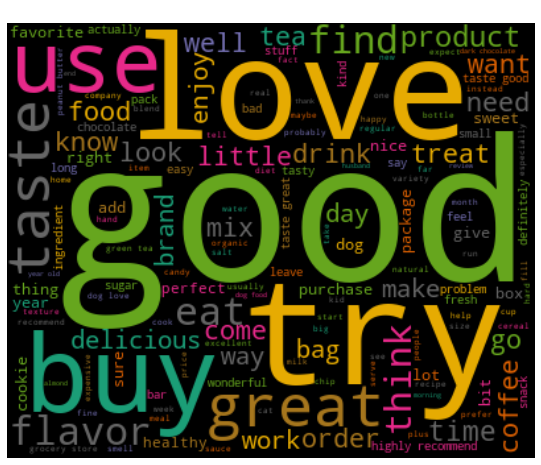

<Figure size 432x288 with 0 Axes>

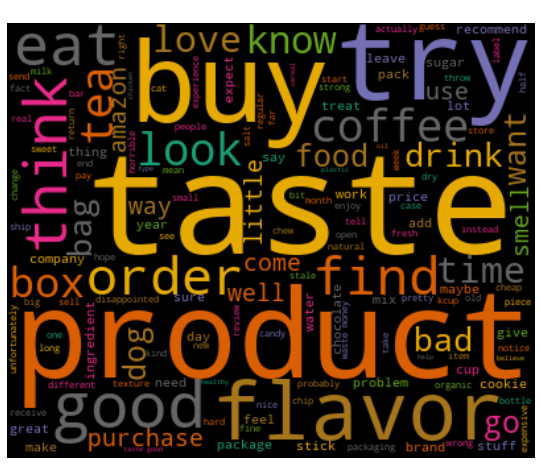

In [25]:
positive_reviews = " ".join(review for review in amazon_reviews_copy[amazon_reviews_copy['sentiment']=='positive']['review'])
negative_reviews = " ".join(review for review in amazon_reviews_copy[amazon_reviews_copy['sentiment']=='negative']['review'])
#wc = WordCloud(width=400, height=330, max_words=150,colormap="Dark2").generate_from_frequencies(df_dtm.transpose()[2])
wc = WordCloud(width=400, height=330, max_words=150,colormap="Dark2").generate(positive_reviews)
plt.figure(figsize=(10,8))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.title('\n'.join(wrap("Positive Reviews Word Cloud",60)),fontsize=13)
plt.show()
plt.clf()
wc = WordCloud(width=400, height=330, max_words=150,colormap="Dark2").generate(negative_reviews)
plt.figure(figsize=(10,8))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.title('\n'.join(wrap("Negative Reviews Word Cloud",60)),fontsize=13)
plt.show()

### Sentiment Polarity

In [26]:
amazon_reviews_copy['polarity']=amazon_reviews_copy['review'].apply(lambda x:TextBlob(x).sentiment.polarity)

In [27]:
print("3 Random Reviews with Highest Polarity:")
for index,review in enumerate(amazon_reviews_copy.iloc[amazon_reviews_copy['polarity'].sort_values(ascending=False)[:3].index]['review']):
  print('Review {}:\n'.format(index+1),review)

3 Random Reviews with Highest Polarity:
Review 1:
 wonderful tea hadsmell world tea bag sturdy cup teagreat gift idea tea lover
Review 2:
 give star rating specifically vegetarian counteract fact somebody give star rating reason delicious steak
Review 3:
 son eat fussy teething etc eat taste delicious mix baby cereal formula


In [28]:
print("3 Random Reviews with Lowest Polarity:")
for index,review in enumerate(amazon_reviews_copy.iloc[amazon_reviews_copy['polarity'].sort_values(ascending=True)[:3].index]['review']):
  print('Review {}:\n'.format(index+1),review)

3 Random Reviews with Lowest Polarity:
Review 1:
 send mother help grocery fix income say horrible throw box reccomend product
Review 2:
 noodle pasty smell horrible fishyjust suggestion diet skip noodle
Review 3:
 terrible product follow intruction pork rind get piece pork skin


In [32]:
amazon_reviews_copy['sentiment'].value_counts()

positive    39511
negative    11808
Name: sentiment, dtype: int64

In [33]:
amazon_reviews_copy['sentiment'].value_counts(normalize=True)

positive    0.76991
negative    0.23009
Name: sentiment, dtype: float64

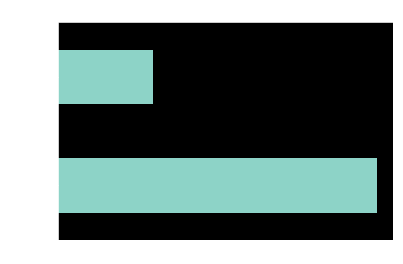

In [34]:
plot=amazon_reviews_copy['sentiment'].value_counts().plot(kind='barh', title="Number of documents per category")

In [36]:
amazon_reviews_copy['polarity'].iplot()

In [37]:
amazon_reviews_copy['polarity'].iplot(kind='hist', xTitle="Polarity", yTitle="Count", title="Sentiment Polarity Distribution")

In [38]:
positive_sentiment_polarity = amazon_reviews_copy[amazon_reviews_copy["sentiment"]=="positive"]["polarity"]
negative_sentiment_polarity = amazon_reviews_copy[amazon_reviews_copy["sentiment"]=="negative"]["polarity"]

In [39]:
trace_positive = go.Histogram(x=positive_sentiment_polarity, name="Positive", opacity=0.8)

In [40]:
trace_negative = go.Histogram(x=negative_sentiment_polarity, name="Negative", opacity=0.8)

In [41]:
fig=go.Figure(data=[trace_positive,trace_negative])

In [42]:
iplot(fig)

### Word Count

In [43]:
amazon_reviews_copy['word count'] = amazon_reviews_copy['review'].apply(lambda x: len(x.split()))

In [44]:
def avg_word_count(word_count_column):
    count=0
    for x in word_count_column:
        count+=x
    return count / len(word_count_column)

In [45]:
print("Average number of words per review: " + str(avg_word_count(amazon_reviews_copy['word count'])))

Average number of words per review: 32.13305013737602


In [46]:
def avg_word_length(sentence):
    count=0
    for x in sentence.split():
        count+=len(x)
    return count / len(sentence.split())

In [47]:
amazon_reviews_copy['avg word length'] = amazon_reviews_copy['review'].apply(lambda x: avg_word_length(x))

In [48]:
print("Max number of words in a review: " + str(max(amazon_reviews_copy['word count'])))

Max number of words in a review: 214


In [49]:
print("Min number of words in a review: " + str(min(amazon_reviews_copy['word count'])))

Min number of words in a review: 2


### Describe

In [50]:
amazon_reviews_copy[["polarity", "word count", "sentiment"]].describe(include=['object','integer','float'])

polarity    word count sentiment
count   51319.000000  51319.000000     51319
unique           NaN           NaN         2
top              NaN           NaN  positive
freq             NaN           NaN     39511
mean        0.224939     32.133050       NaN
std         0.252026     25.212761       NaN
min        -1.000000      2.000000       NaN
25%         0.074117     15.000000       NaN
50%         0.227083     24.000000       NaN
75%         0.383019     41.000000       NaN
max         1.000000    214.000000       NaN

### Readability, complexity and grade level of the corpus

In [51]:
amazon_reviews_copy['dale_chall_score']=amazon_reviews_copy['review'].apply(lambda x: textstat.dale_chall_readability_score(x))
amazon_reviews_copy['flesh_reading_ease']=amazon_reviews_copy['review'].apply(lambda x: textstat.flesch_reading_ease(x))
amazon_reviews_copy['gunning_fog']=amazon_reviews_copy['review'].apply(lambda x: textstat.gunning_fog(x))

print('Dale Chall Score of positive reviews: ',amazon_reviews_copy[amazon_reviews_copy["sentiment"]=="positive"]['dale_chall_score'].mean())
print('Dale Chall Score of negative reviews: ',amazon_reviews_copy[amazon_reviews_copy["sentiment"]=="negative"]['dale_chall_score'].mean())

print('Flesch Reading Score of positive reviews: ',amazon_reviews_copy[amazon_reviews_copy["sentiment"]=="positive"]['flesh_reading_ease'].mean())
print('Flesch Reading Score of negative reviews: ',amazon_reviews_copy[amazon_reviews_copy["sentiment"]=="negative"]['flesh_reading_ease'].mean())

print('Gunning Fog Index of positive reviews: ',amazon_reviews_copy[amazon_reviews_copy["sentiment"]=="positive"]['gunning_fog'].mean())
print('Gunning Fog Index of negative reviews: ',amazon_reviews_copy[amazon_reviews_copy["sentiment"]=="negative"]['gunning_fog'].mean())

Dale Chall Score of positive reviews:  10.29736402520792
Dale Chall Score of negative reviews:  10.391839430894192
Flesch Reading Score of positive reviews:  43.99669155425038
Flesch Reading Score of negative reviews:  38.36911924119224
Gunning Fog Index of positive reviews:  16.455708536863767
Gunning Fog Index of negative reviews:  17.65518885501352


In [52]:
amazon_reviews_copy['text_standard']=amazon_reviews_copy['review'].apply(lambda x: textstat.text_standard(x))

print('Text Standard of positive reviews=>',amazon_reviews_copy[amazon_reviews_copy['sentiment']=='positive']['text_standard'].mode())
print('Text Standard of negative reviews=>',amazon_reviews_copy[amazon_reviews_copy['sentiment']=='negative']['text_standard'].mode())

Text Standard of positive reviews=> 0    12th and 13th grade
dtype: object
Text Standard of negative reviews=> 0    12th and 13th grade
dtype: object


In [53]:
amazon_reviews_copy['reading_time']=amazon_reviews_copy['review'].apply(lambda x: textstat.reading_time(x))

print('Reading Time of upvoted reviews=>',amazon_reviews_copy[amazon_reviews_copy['sentiment']=='positive']['reading_time'].mean())
print('Reading Time of not upvoted reviews=>',amazon_reviews_copy[amazon_reviews_copy['sentiment']=='negative']['reading_time'].mean())

Reading Time of upvoted reviews=> 2.51498974968985
Reading Time of not upvoted reviews=> 2.7589142953929056


### Dataset Balance

This dataset is a little bit unbalanced...

Let's try to resample with SMOTE

In [59]:
# This stratified sampling split is important to guarantee the same class balance in train and test
train, test = train_test_split(amazon_reviews_copy, test_size = 0.2, \
                               stratify=amazon_reviews_copy.sentiment)

In [65]:
train['sentiment'].value_counts()

positive    31609
negative     9446
Name: sentiment, dtype: int64

In [62]:
train['sentiment'].value_counts(normalize=True)

positive    0.769918
negative    0.230082
Name: sentiment, dtype: float64

In [66]:
test['sentiment'].value_counts()

positive    7902
negative    2362
Name: sentiment, dtype: int64

In [64]:
test['sentiment'].value_counts(normalize=True)

positive    0.769875
negative    0.230125
Name: sentiment, dtype: float64

## 4 - Document Representation

In [ ]:
count_vectorizer = CountVectorizer(ngram_range=(4,4))
train_X = count_vectorizer.fit_transform(amazon_reviews_train['review'])
test_X = count_vectorizer.transform(amazon_reviews_test['review'])
print(train_X.shape, test_X.shape)

In [76]:
# Creating a Bag odf Words Representation
#bow_1gram_vector = CountVectorizer(analyzer='word', ngram_range=(1,1))
bow_1gram_vector = CountVectorizer(analyzer='word', ngram_range=(1,1))
train_X_bow_1gram = bow_1gram_vector.fit_transform(train['review'])
test_X_bow_1gram = bow_1gram_vector.transform(test['review'])
print(train_X_bow_1gram.shape, test_X_bow_1gram.shape)
# Analyze some data
df_dtm = pd.DataFrame(train_X_bow_1gram[:2000].toarray(), columns=bow_1gram_vector.get_feature_names())
df_dtm.index=train_X_bow_1gram[:2000].index
df_dtm.head(3)

(41055, 38489) (10264, 38489)


AttributeError: index not found

In [ ]:
sm = SMOTE(random_state=12, ratio = 1.0)
train_X_bow_1gram_resampled, test_X_bow_1gram_resampled = sm.fit_sample(train_X_bow_1gram, train['sentiment'])

## 5 - Sentiment Analysis - Text Classification

Baseline (Textblob accuracy)

In [ ]:
reviews = np.array(amazon_reviews_test)

counter = 0
for sent, rev in reviews:
    polarity = TextBlob(rev).sentiment.polarity
    prediction = "positive" if polarity > 0 else "negative"
    if sent == prediction:
        counter += 1
accuracy = counter / len(reviews)

print("TextBlob accuracy = ", accuracy)

Baseline (VaderSentiment accuracy)

In [ ]:
analyzer = SentimentIntensityAnalyzer()
    
counter = 0
for sent, rev in reviews:
    vs = analyzer.polarity_scores(rev)
#     prediction = "positive" if vs["pos"] > vs["neg"] else "negative"
    prediction = "positive" if vs["compound"] > 0 else "negative"
    if sent == prediction:
        counter += 1
precision = counter / len(reviews)

print("VaderSentiment precision = ", precision)

In [ ]:
df_dict = pd.read_csv("NCR-lexicon.csv", encoding="utf-8")

In [ ]:
def getSentiment(text):
    freq=collections.Counter(text.split())
#     print(freq)

    count = 0
    for word in freq:
        
        positive = df_dict[df_dict['English']==word]['Positive']
        negative = df_dict[df_dict['English']==word]['Negative']
        if len(positive) > 0:
            count += positive.values[0]
        if len(negative) > 0:
            count -= negative.values[0]
        
    return(count)

In [ ]:
def getPrecision(dataset):
    counter = 0
    for sent, rev in reviews:
        
        prediction = "positive" if getSentiment(rev)>0 else "negative"
        
        if sent == prediction:
            counter += 1
            
    return counter / len(reviews)

# !!! --- Important: resource consuming operations below
print("GetSentiment precision = ", getPrecision(reviews))

In [ ]:
def getPrecisionL(dataset):
    counter = 0
    for sent, rev in reviews:
        
        text = TextBlob(rev)
        lemmatized_text = " ". join([w.lemmatize() for w in text.words])
        prediction = "positive" if getSentiment(lemmatized_text)>0 else "negative"
        
        if sent == prediction:
            counter += 1
            
    return counter / len(reviews)

# !!! --- Important: resource consuming operations below
print("GetSentiment Lemmatizated precision = ", getPrecisionL(reviews))

TextBlob precision =  0.7641704592470004

VaderSentiment precision =  0.7931319817956144

GetSentiment precision =  0.6379809681423252

GetSentiment Lemmatizated precision =  0.6652875465453041

Negation treatment

In [ ]:
negatives = ["no", "not", "No", "Not", "none"]

def getSentimentNegation(text):
    sentences = sent_tokenize(text)
#     print(sentences)
    count = 0
    for sentence in sentences:
        # use lemmatization
#         sentence = TextBlob(sentence) 
#         " ". join([w.lemmatize() for w in sentence.words])
        
        negation = False
        words = sentence.split()
#         print(words)
        for word in words:
            # check if the word is negative
            if word  in negatives:
                # then polarity should be switched to opposite
                negation = True
#                 print("Negative! ", word)
                # and should not evaluate the negation itself
                continue
            positive = df_dict[df_dict['English']==word]['Positive']
            negative = df_dict[df_dict['English']==word]['Negative']
#             print(positive)
#             print(negative)
            
            if len(positive) > 0:
                # if there was negation, the polarity opposite
                if negation:
                    count -= positive.values[0]
                else:
                    count += positive.values[0]
            if len(negative) > 0:
                if negation:
                    count += negative.values[0]
                else:
                    count -= negative.values[0]
            negation = False  
    return(count)

In [ ]:
def getPrecisionNegation(dataset):
    counter = 0
    for sent, rev in reviews:
        
        prediction = "positive" if getSentimentNegation(rev)>0 else "negative"
        
        if sent == prediction:
            counter += 1
#         print(sent, "->", prediction)
    return counter / len(reviews)

# !!! --- Important: resource consuming operations below
reviews = np.array(amazon_reviews_test[:100])
print("GetSentiment precision = ", getPrecisionNegation(reviews))

In [ ]:
# Define function to lemmatize each word with its POS tag
def lemmatize_with_postag(sentence):
    sent = TextBlob(sentence)
    tag_dict = {"J": 'a', 
                "N": 'n', 
                "V": 'v', 
                "R": 'r'}
    words_and_tags = [(w, tag_dict.get(pos[0], 'n')) for w, pos in sent.tags]    
    lemmatized_list = [wd.lemmatize(tag) for wd, tag in words_and_tags]
    return " ".join(lemmatized_list)

In [ ]:
# converts a text to a sequence of words.
def clean_text(review, remove_stopwords=True):
    # 1. Removing html tags
    review_text = BeautifulSoup(review).get_text()
    # 2. Removing non-letter.
    review_text = re.sub("[^a-zA-Z]"," ",review_text)
    # 3. Converting to lower case and splitting
    words = review_text.lower().split()
    # 4. Optionally remove stopwords
    if remove_stopwords:
        stops = set(stopwords.words("english"))     
        words = [w for w in words if not w in stops]
    
    return(' '.join(words))

Embeddings

In [ ]:
# max words count in rewievs
dataset = list(train) + list(test)
words_count = [len(t.split()) for t in dataset]
print(max(words_count))

In [ ]:
# uniq words count
listing = [t.split() for t in dataset]
unique = set()
for elem in listing:
    for word in elem:
        unique.add(word)
print(len(unique))

In [ ]:
# vocabulary size
vocab_size = 1000
# word encoding
encoded_train = [one_hot(d, vocab_size) for d in train]
encoded_test = [one_hot(d, vocab_size) for d in test]

In [ ]:
# max length bigger than max words count in rewievs
max_length = 450
padded_train = pad_sequences(encoded_train, maxlen=max_length, padding='post')
padded_test = pad_sequences(encoded_test, maxlen=max_length, padding='post')

In [ ]:
# define the model
# model = Sequential()
# model.add(Embedding(input_dim=vocab_size, output_dim=8, input_length=max_length))
# model.add(Flatten())
# model.add(Dense(1, activation='sigmoid'))

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=16, input_length=max_length))
model.add(GlobalAveragePooling1D())
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

print(model.summary())

model.fit(padded_train, train_labels, epochs=50, verbose=0)

loss, accuracy = model.evaluate(padded_test, test_labels, verbose=0)
print('Accuracy: %f' % (accuracy*100))

In [ ]:
# Creating the model and setting values for the various parameters
num_features = 300  # Word vector dimensionality
min_word_count = 40 # Minimum word count
num_workers = 2     # Number of parallel threads
context = 10        # Context window size
downsampling = 1e-3 # (0.001) Downsample setting for frequent words

# Initializing the train model
from gensim.models import word2vec
print("Training model....")
model = word2vec.Word2Vec(train,\
                          workers=num_workers,\
                          size=num_features,\
                          min_count=min_word_count,\
                          window=context,
                          sample=downsampling)

# To make the model memory efficient
model.init_sims(replace=True)

In [ ]:
model = Sequential()
model.add(Embedding(input_dim=10000, output_dim=16, input_length=256))
model.add(GlobalAveragePooling1D())
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

In [ ]:
count_vectorizer = CountVectorizer(ngram_range=(4,4))
train_X = count_vectorizer.fit_transform(amazon_reviews_train['review'])
test_X = count_vectorizer.transform(amazon_reviews_test['review'])
print(train_X.shape, test_X.shape)

In [ ]:
print(vectorizer.get_feature_names()[2000:2300])

In [ ]:
random_forest_classifier = RandomForestClassifier()
random_forest_classifier.fit(train_X, amazon_reviews_train['sentiment'])
pred = random_forest_classifier.predict(test_X)
score = sklearn.metrics.accuracy_score(amazon_reviews_test['sentiment'], pred)
print("accuracy:   %0.3f" % score)

In [ ]:
#tfidf_vectorizer = TfidfVectorizer(min_df=1, stop_words='english')
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
train_X = tfidf_vectorizer.fit_transform(amazon_reviews_train['review'])
test_X = tfidf_vectorizer.transform(amazon_reviews_test['review'])
print(train_X.shape, test_X.shape)

gb_classifier = GradientBoostingClassifier()
gb_classifier.fit(train_X, amazon_reviews_train['sentiment'])
pred = gb_classifier.predict(test_X)
score = sklearn.metrics.accuracy_score(amazon_reviews_test['sentiment'], pred)
print("accuracy:   %0.3f" % score)

In [ ]:
classifier = MultinomialNB()

In [ ]:
classifier.fit(train_X, amazon_reviews_train['sentiment'])

In [ ]:
pred = classifier.predict(test_X)

In [ ]:
score = sklearn.metrics.accuracy_score(amazon_reviews_test['sentiment'], pred)
print("accuracy:   %0.3f" % score)

In [ ]:
lr = LogisticRegression(solver = 'liblinear', random_state = 100, max_iter=10000)
lr.fit(train_X,amazon_reviews_train['sentiment'])
y_pred = lr.predict(test_X)
y_true=amazon_reviews_test['sentiment']
score = round(metrics.accuracy_score(y_true,y_pred),3)
print("Accuracy: ",score)

In [ ]:
cm = metrics.confusion_matrix(y_true, y_pred)
print(cm)

In [ ]:
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);

In [ ]:
from imblearn.over_sampling import SMOTE
x_resampled, y_resampled = SMOTE().fit_resample(train_X, amazon_reviews_train['sentiment'])

In [ ]:
pd.Series(y_resampled).value_counts().plot(kind='bar', title='Class distribution after appying SMOTE', xlabel='buy')

In [ ]:
lr = LogisticRegression(solver = 'liblinear', random_state = 82, max_iter=5000)
lr.fit(x_resampled,y_resampled)
y_pred = lr.predict(test_X)
y_true=amazon_reviews_test['sentiment']
score = round(metrics.accuracy_score(y_true,y_pred),3)
print("Accuracy: ",score)

In [ ]:
tfidf_vectorizer = TfidfVectorizer(min_df=1, stop_words='english')
train_X = tfidf_vectorizer.fit_transform(amazon_reviews_train['review'])
test_X = tfidf_vectorizer.transform(amazon_reviews_test['review'])
print(train_X.shape, test_X.shape)

In [ ]:
lr = LogisticRegression(solver = 'liblinear', random_state = 48, max_iter=5000)
lr.fit(train_X,amazon_reviews_train['review'])
y_pred = lr.predict(test_X)
y_true=amazon_reviews_test['sentiment']
score = round(metrics.accuracy_score(y_true,y_pred),3)
print("Accuracy: ",score)